In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv
/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv
/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset_info.txt


In [2]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

In [3]:
train1_df = pd.read_csv('/kaggle/input/playground-series-s5e4/train.csv')
train2_df = pd.read_csv('/kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e4/test.csv')

In [4]:
# Count duplicates in each
n_duplicates_1 = train1_df.duplicated().sum()
n_duplicates_2 = train2_df.duplicated().sum()

print(f"\nNumber of duplicates in train1_df: {n_duplicates_1}")
print(f"\nNumber of duplicates in train2_df: {n_duplicates_2}")

# Drop duplicates
train1_df = train1_df.drop_duplicates()
train2_df = train2_df.drop_duplicates()

# Concatenate the cleaned datasets
train_df = pd.concat([train1_df, train2_df], ignore_index=True)

# Drop 'id' column
train_df = train_df.drop(columns=["id"])

# Final check
print(f"\nFinal dataset shape: {train_df.shape}")
train_df.info()


Number of duplicates in train1_df: 0

Number of duplicates in train2_df: 2500

Final dataset shape: (800000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 800000 non-null  object 
 1   Episode_Title                800000 non-null  object 
 2   Episode_Length_minutes       707882 non-null  float64
 3   Genre                        800000 non-null  object 
 4   Host_Popularity_percentage   800000 non-null  float64
 5   Publication_Day              800000 non-null  object 
 6   Publication_Time             800000 non-null  object 
 7   Guest_Popularity_percentage  648984 non-null  float64
 8   Number_of_Ads                799999 non-null  float64
 9   Episode_Sentiment            800000 non-null  object 
 10  Listening_Time_minutes       794868 non-null  float64
dtypes: 

In [5]:
# Save 'id' column for submission
test_ids = test_df['id']

# Define the target column
target_column = 'Listening_Time_minutes'

# Select categorical and numerical columns (initial)
categorical_columns = train_df.select_dtypes(include=['object']).columns
numerical_columns = train_df.select_dtypes(exclude=['object']).columns

# Print out column information
print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())

Target Column: Listening_Time_minutes

Categorical Columns: ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

Numerical Columns: ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes']


In [6]:
train_df.head(5)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [7]:
train_df.round(2).describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,707882.000000,800000.000000,648984.000000,799999.000000,794868.000000
mean,64.399933,59.878370,52.086840,1.358224,45.443272
std,32.982345,22.890414,28.485915,1.149614,27.138473
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.670000,39.450000,28.090000,0.000000,23.180000
50%,63.760000,60.060000,53.330000,1.000000,43.390000
75%,93.990000,79.560000,76.482500,2.000000,64.810000
max,325.240000,119.460000,119.910000,103.910000,119.970000


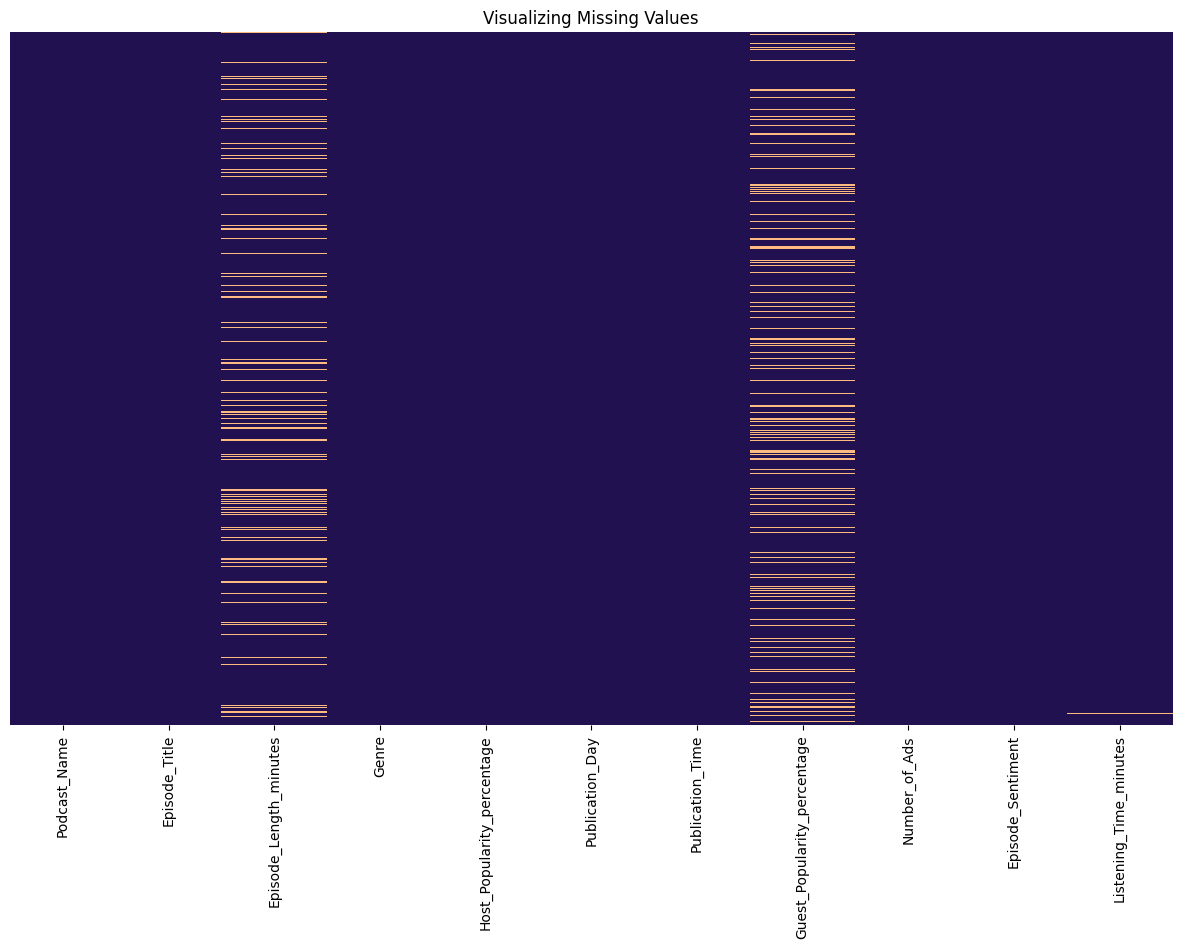

In [8]:
plt.figure(figsize=(15,9))
plt.title("Visualizing Missing Values")
sns.heatmap(train_df.isnull(), cbar=False, cmap=sns.color_palette('magma'), yticklabels=False);
plt.show()

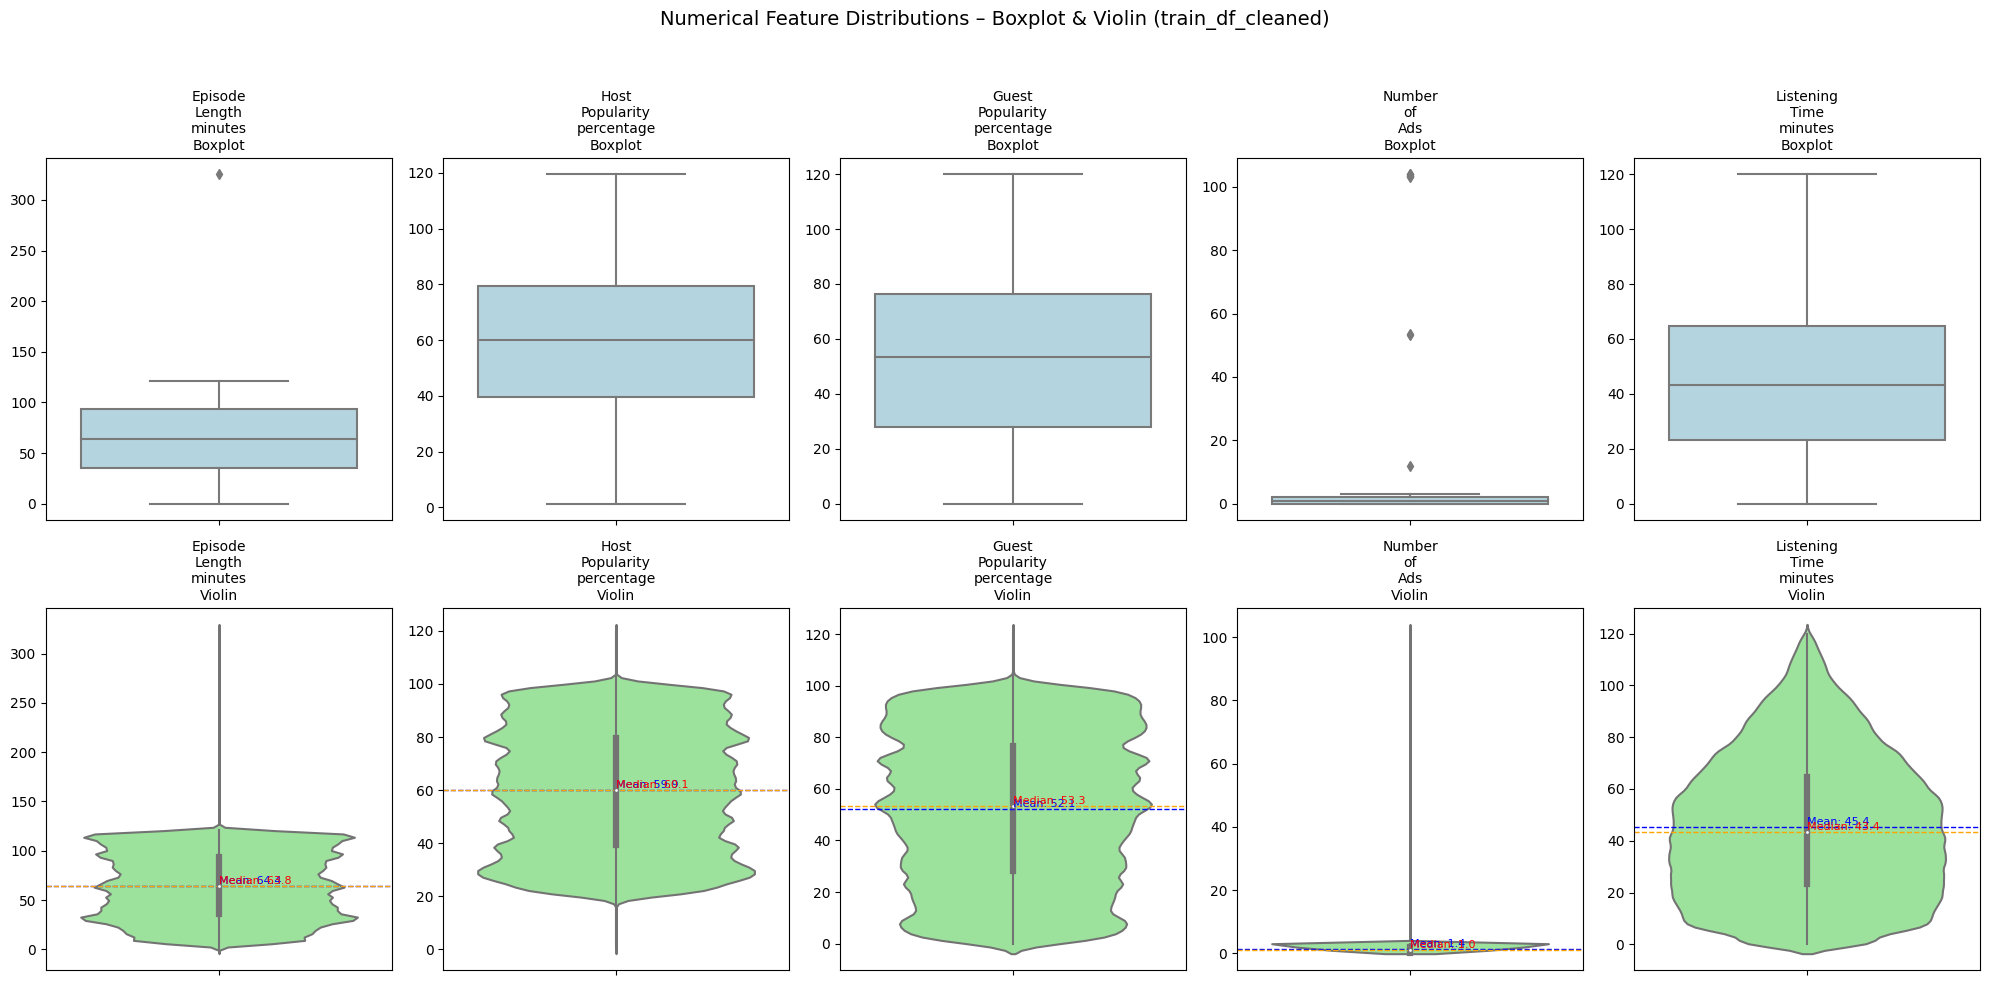

In [9]:
# Création des sous-graphiques : boxplots en haut, violins en bas
fig, axes = plt.subplots(nrows=2, ncols=len(numerical_columns), figsize=(4 * len(numerical_columns), 10), sharey=False)

for i, feature in enumerate(numerical_columns):
    # Préparer le label en remplaçant les underscores par des sauts de ligne
    feature_label = feature.replace('_', '\n')
    
    # Boxplot en haut
    sns.boxplot(y=train_df[feature], ax=axes[0, i], color='lightblue')
    axes[0, i].set_title(f"{feature_label}\nBoxplot", fontsize=10)
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel('')
    
    # Violin plot en bas avec la boîte interne
    sns.violinplot(y=train_df[feature], ax=axes[1, i], inner='box', color='lightgreen')
    
    # Calcul des statistiques
    mean_val = train_df[feature].mean()
    median_val = train_df[feature].median()
    
    # Annotation de la moyenne
    axes[1, i].axhline(mean_val, color='blue', linestyle='--', linewidth=1)
    axes[1, i].text(0, mean_val, f"Mean: {mean_val:.1f}", color='blue', fontsize=8, va='bottom')
    
    # Annotation de la médiane
    axes[1, i].axhline(median_val, color='orange', linestyle='--', linewidth=1)
    axes[1, i].text(0, median_val, f"Median: {median_val:.1f}", color='red', fontsize=8, va='bottom')
    
    axes[1, i].set_title(f"{feature_label}\nViolin", fontsize=10)
    axes[1, i].set_xlabel('')
    axes[1, i].set_ylabel('')

fig.suptitle('Numerical Feature Distributions – Boxplot & Violin (train_df_cleaned)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: Ru

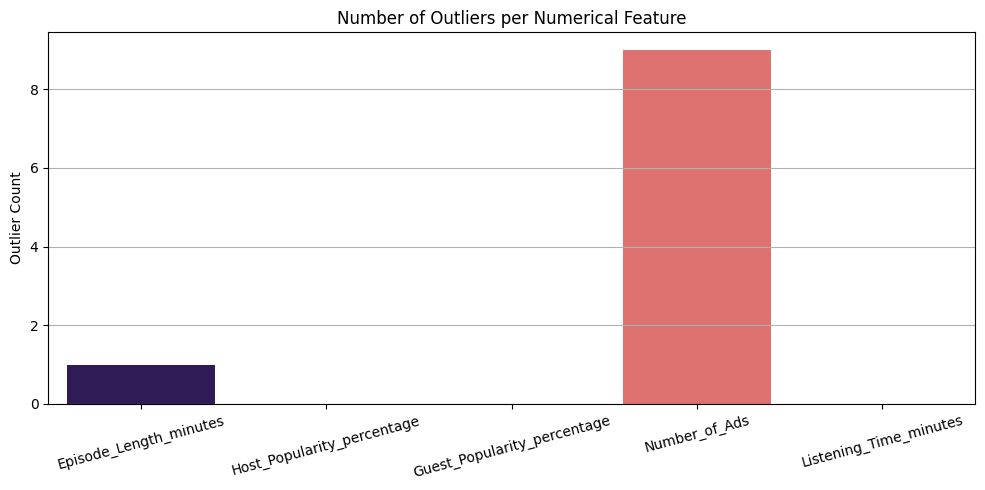

In [10]:
# Compute outliers using IQR method
outlier_counts = {}

for feature in numerical_columns:
    q1 = train_df[feature].quantile(0.25)
    q3 = train_df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]
    outlier_counts[feature] = outliers.shape[0]

# Plot the number of outliers
plt.figure(figsize=(10, 5))
sns.barplot(x=list(outlier_counts.keys()), y=list(outlier_counts.values()), palette='magma')
plt.title("Number of Outliers per Numerical Feature")
plt.ylabel("Outlier Count")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [11]:
# Make a copy of the dataset
train_df_cleaned = train_df.copy()

for feature in numerical_columns:
    q1 = train_df[feature].quantile(0.25)
    q3 = train_df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Boolean mask of outliers
    is_outlier = (train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)

    for idx in train_df[is_outlier].index:
        podcast = train_df.loc[idx, 'Podcast_Name']

        # Median of the group (excluding outliers)
        group_values = train_df[(train_df['Podcast_Name'] == podcast) & ~is_outlier][feature]
        if not group_values.empty:
            replacement = group_values.median()
        else:
            replacement = train_df[~is_outlier][feature].median()

        train_df_cleaned.at[idx, feature] = replacement

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: Ru

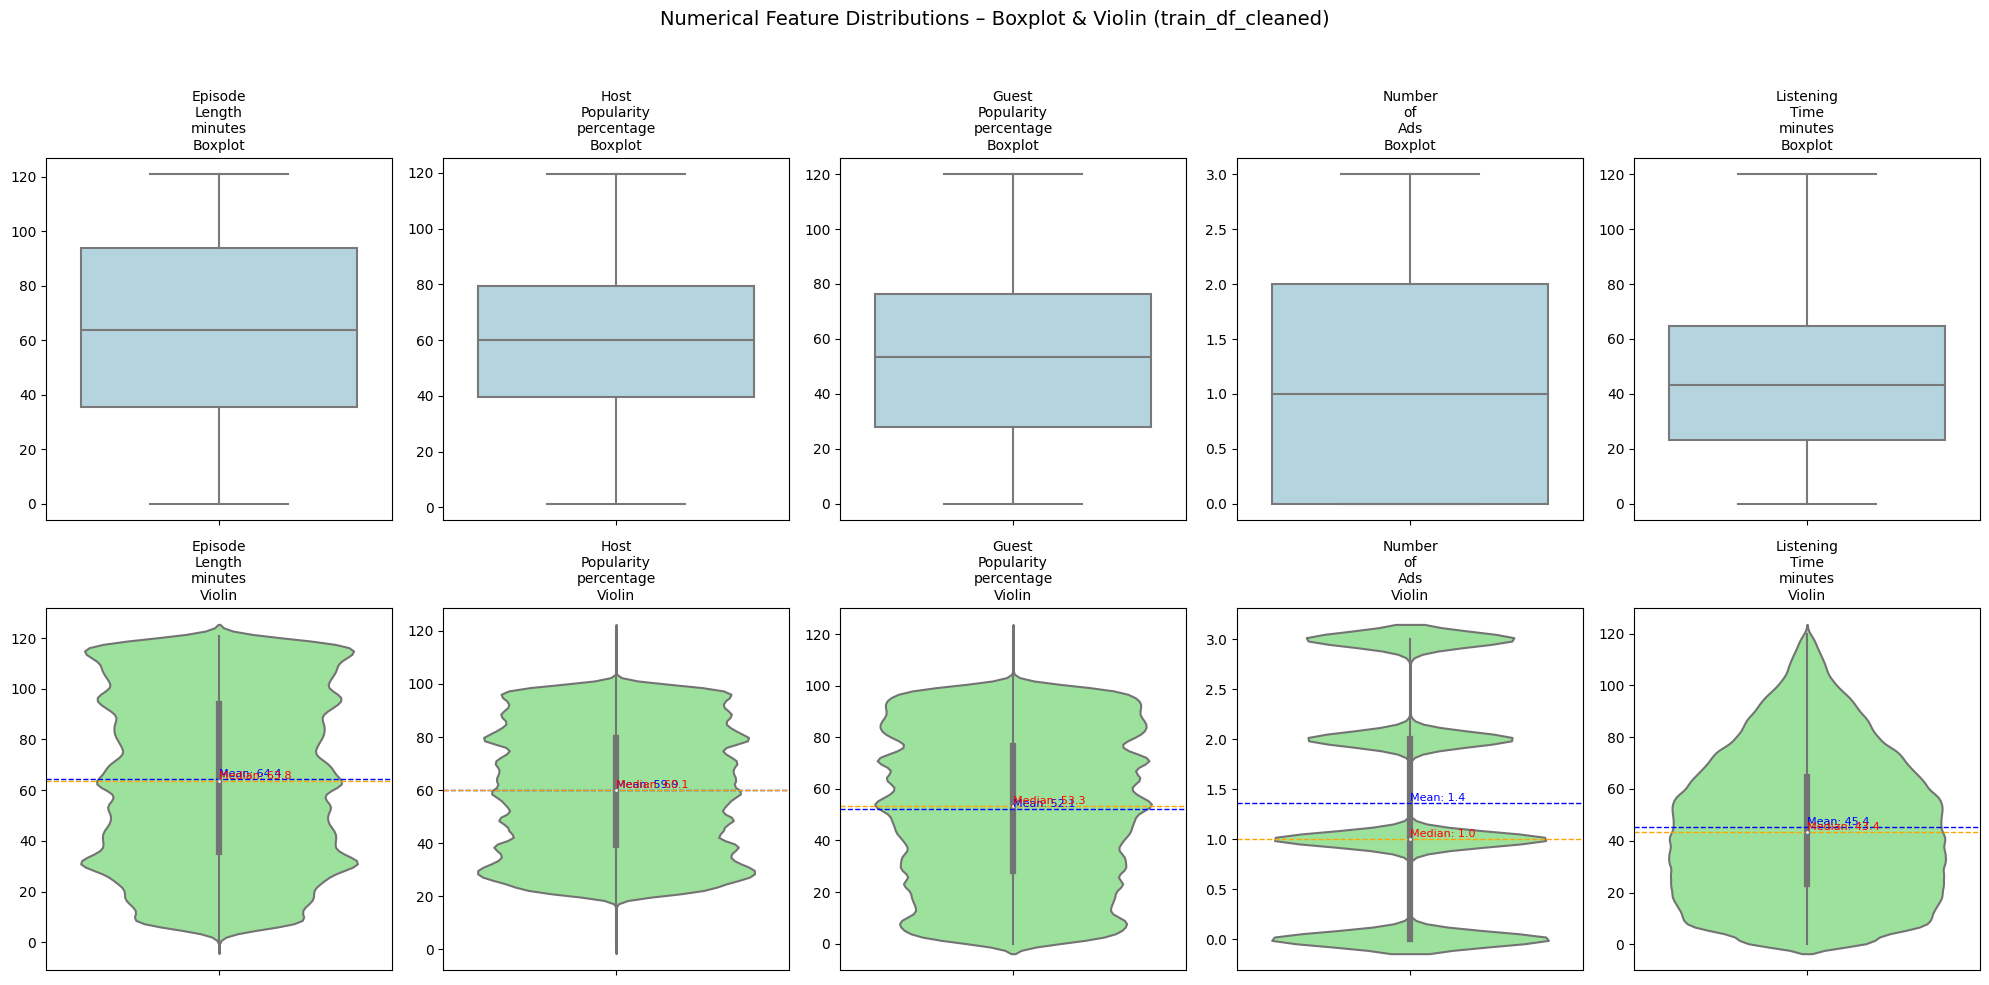

In [12]:
# Création des sous-graphes : boxplots en haut, violins en bas
fig, axes = plt.subplots(nrows=2, ncols=len(numerical_columns), figsize=(4 * len(numerical_columns), 10), sharey=False)

for i, feature in enumerate(numerical_columns):
    feature_label = feature.replace('_', '\n')

    # Boxplot en haut
    sns.boxplot(y=train_df_cleaned[feature], ax=axes[0, i], color='lightblue')
    axes[0, i].set_title(f"{feature_label}\nBoxplot", fontsize=10)
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel('')

    # Violin plot en bas avec moyenne et médiane
    sns.violinplot(y=train_df_cleaned[feature], ax=axes[1, i], inner='box', color='lightgreen')
    
    mean_val = train_df_cleaned[feature].mean()
    median_val = train_df_cleaned[feature].median()
    
    axes[1, i].axhline(mean_val, color='blue', linestyle='--', linewidth=1)
    axes[1, i].text(0, mean_val, f"Mean: {mean_val:.1f}", color='blue', fontsize=8, va='bottom')
    
    axes[1, i].axhline(median_val, color='orange', linestyle='--', linewidth=1)
    axes[1, i].text(0, median_val, f"Median: {median_val:.1f}", color='red', fontsize=8, va='bottom')
    
    axes[1, i].set_title(f"{feature_label}\nViolin", fontsize=10)
    axes[1, i].set_xlabel('')
    axes[1, i].set_ylabel('')

fig.suptitle('Numerical Feature Distributions – Boxplot & Violin (train_df_cleaned)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

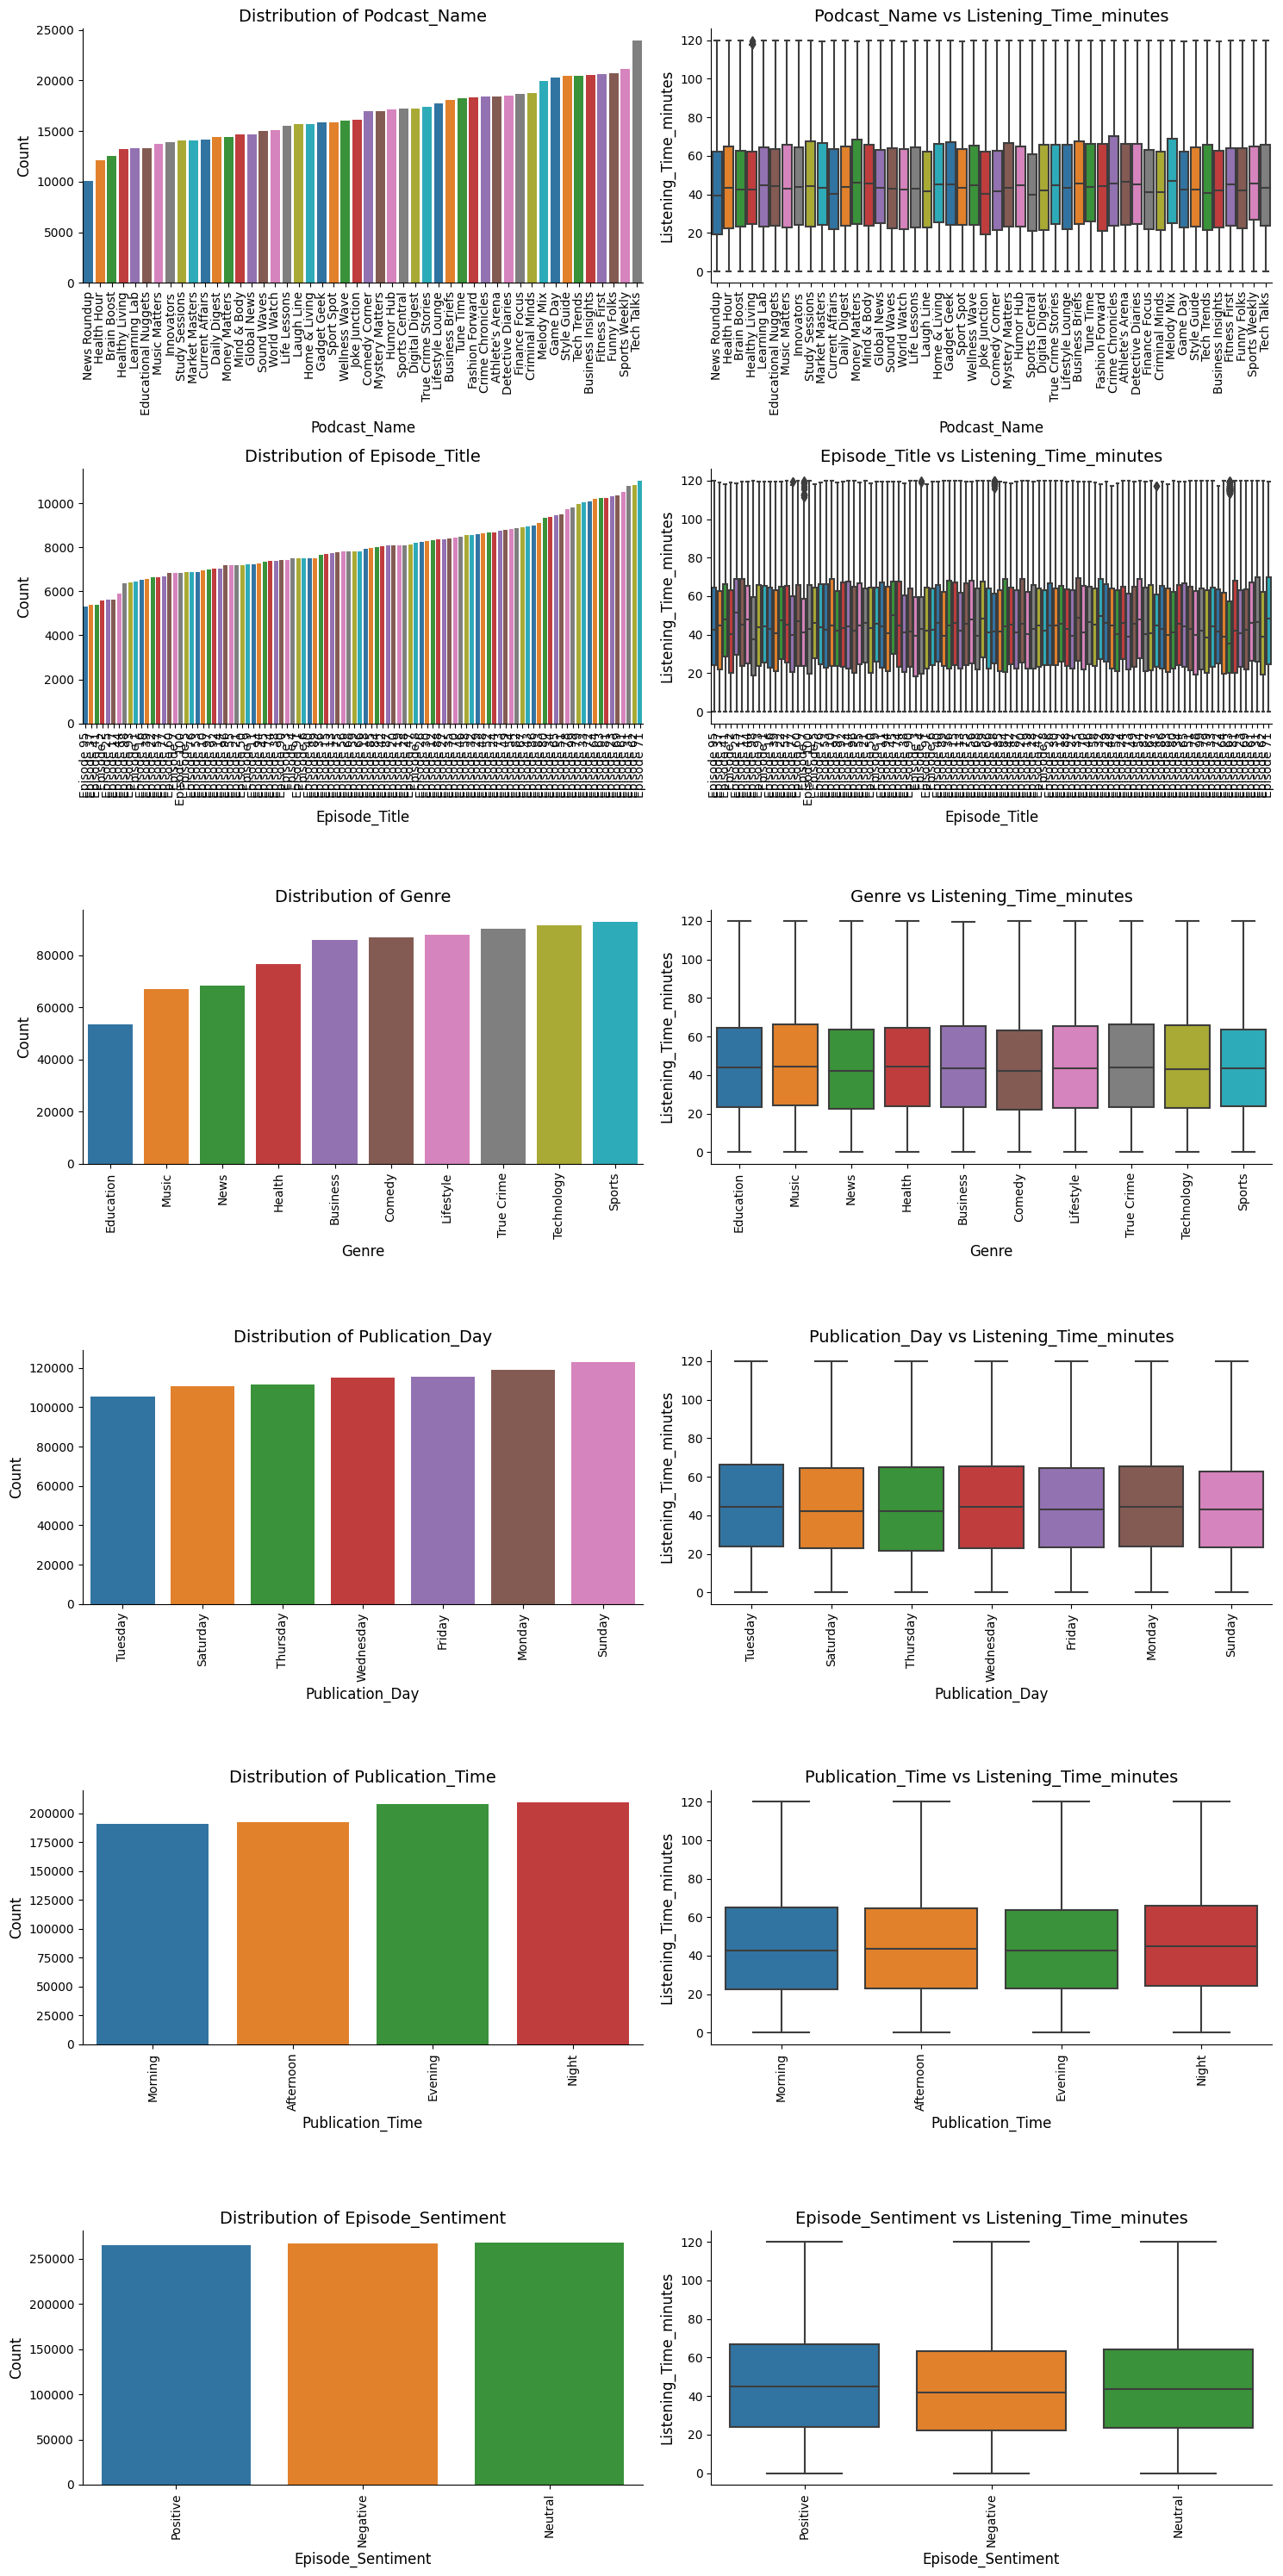

In [13]:
# Création des sous-graphiques pour chaque variable catégorielle
fig, axes = plt.subplots(len(categorical_columns), 2, figsize=(15, 5 * len(categorical_columns)))

for i, column in enumerate(categorical_columns):
    # Ordre croissant des catégories selon la fréquence
    order = train_df_cleaned[column].value_counts(ascending=True).index

    # Barplot (gauche)
    sns.countplot(data=train_df_cleaned, x=column, ax=axes[i, 0], order=order, palette='tab10')
    axes[i, 0].set_title(f'Distribution of {column}', fontsize=14)
    axes[i, 0].set_xlabel(column, fontsize=12)
    axes[i, 0].set_ylabel('Count', fontsize=12)
    axes[i, 0].tick_params(axis='x', rotation=90)
    sns.despine(ax=axes[i, 0])

    # Boxplot (droite)
    sns.boxplot(data=train_df_cleaned, x=column, y=target_column, ax=axes[i, 1], order=order, palette='tab10')
    axes[i, 1].set_title(f'{column} vs {target_column}', fontsize=14)
    axes[i, 1].set_xlabel(column, fontsize=12)
    axes[i, 1].set_ylabel(target_column, fontsize=12)
    axes[i, 1].tick_params(axis='x', rotation=90)
    sns.despine(ax=axes[i, 1])

plt.tight_layout()
plt.show()

In [14]:
# Extraire le nombre de la colonne 'Episode_Title' et le convertir en int
train_df_cleaned['Episode_Number'] = train_df_cleaned['Episode_Title'].str.extract('(\d+)').astype(int)

In [15]:
import numpy as np

# Mapping initial des catégories
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
               'Friday': 4, 'Saturday': 5, 'Sunday': 6}

time_mapping = {'Morning': 9, 'Afternoon': 14, 'Evening': 19, 'Night': 23}

sentiment_mapping = {'Negative': 1, 'Neutral': 2, 'Positive': 3}

# Encodage numérique initial
train_df_cleaned['Publication_Day_num'] = train_df_cleaned['Publication_Day'].map(day_mapping)
train_df_cleaned['Publication_Time_num'] = train_df_cleaned['Publication_Time'].map(time_mapping)
train_df_cleaned['Episode_Sentiment_num'] = train_df_cleaned['Episode_Sentiment'].map(sentiment_mapping)

# Encodage cyclique (jour sur 7, heure sur 24, sentiment sur 3)
train_df_cleaned['Publication_Day_sin'] = np.sin(2 * np.pi * train_df_cleaned['Publication_Day_num'] / 7)
train_df_cleaned['Publication_Day_cos'] = np.cos(2 * np.pi * train_df_cleaned['Publication_Day_num'] / 7)

train_df_cleaned['Publication_Time_sin'] = np.sin(2 * np.pi * train_df_cleaned['Publication_Time_num'] / 24)
train_df_cleaned['Publication_Time_cos'] = np.cos(2 * np.pi * train_df_cleaned['Publication_Time_num'] / 24)

In [16]:
# Liste des colonnes catégorielles à encoder
categorical_columns = ['Podcast_Name', 'Genre']

# Boucle sur chaque colonne
for col in categorical_columns:
    # Initialiser la nouvelle colonne d'encodage cible
    train_df_cleaned[f'{col}_TE'] = np.nan

    # Configuration de la validation croisée
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(train_df):
        # Calculer la moyenne de la cible pour chaque modalité sur l'ensemble d'entraînement
        means = train_df_cleaned.iloc[train_idx].groupby(col)[target_column].mean()
        # Appliquer ces moyennes sur la partie validation
        train_df_cleaned.loc[train_df_cleaned.index[val_idx], f'{col}_TE'] = train_df_cleaned.iloc[val_idx][col].map(means)

    # Remplacer les valeurs manquantes (modalités non rencontrées) par la moyenne globale de la cible
    global_mean = train_df_cleaned[target_column].mean()
    train_df_cleaned[f'{col}_TE'] = train_df_cleaned[f'{col}_TE'].fillna(global_mean)


In [17]:
# Suppression des colonnes intermédiaires
train_df_cleaned = train_df_cleaned.drop(['Publication_Day_num', 'Publication_Time_num', 'Episode_Sentiment_num','Podcast_Name','Genre','Episode_Title'], axis=1)

# Update categorical and numerical columns (initial)
categorical_columns = train_df_cleaned.select_dtypes(include=['object']).columns
numerical_columns = train_df_cleaned.select_dtypes(exclude=['object']).columns

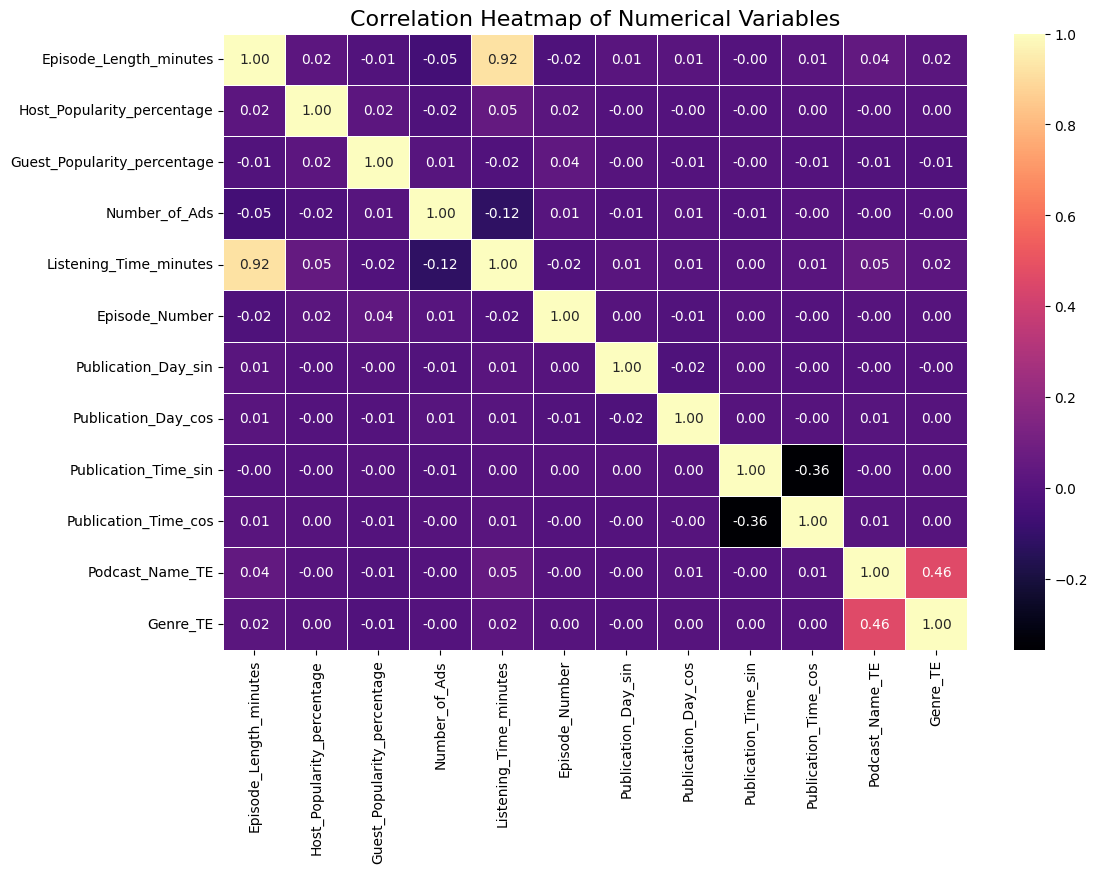

In [18]:
# Calculate the correlation matrix
correlation_matrix = train_df_cleaned[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="magma", cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables", fontsize=16)
plt.show()

In [19]:
# Copier les données nettoyées pour l'EDA
df_eda = train_df_cleaned.copy()
cols_to_use = [col for col in numerical_columns if col not in [target_column]]

# Sélectionner les colonnes numériques à utiliser
X_eda = df_eda[cols_to_use]

# Imputer les valeurs manquantes avec la médiane en utilisant sklearn
imputer = SimpleImputer(strategy='median')
X_eda_imputed = imputer.fit_transform(X_eda)

# Standardiser les features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eda_imputed)

# PCA sur 2 composantes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Insérer les résultats de la PCA dans df_eda
df_eda["PC1"] = X_pca[:, 0]
df_eda["PC2"] = X_pca[:, 1]

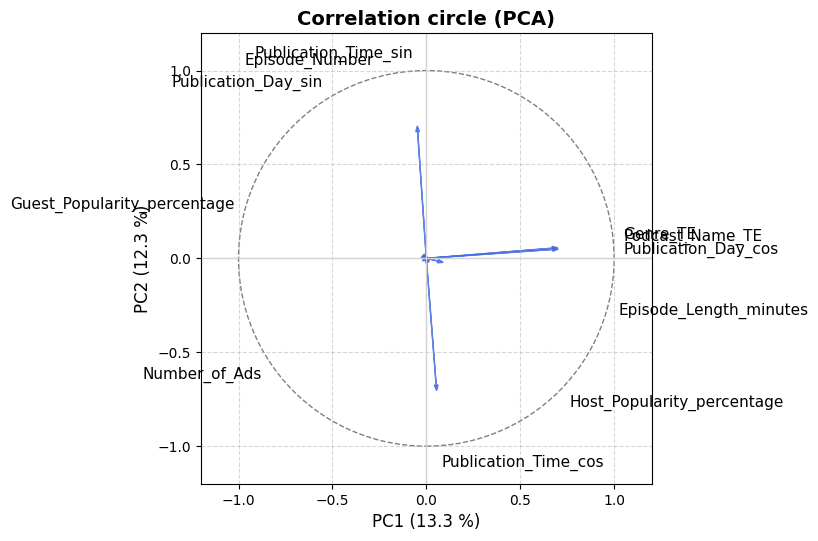

In [20]:
# Retrieve from previous PCA
components = pca.components_
explained_var = pca.explained_variance_ratio_
feature_names = cols_to_use

# Plot
plt.figure(figsize=(8, 8))
plt.axhline(0, color='lightgray', linewidth=1)
plt.axvline(0, color='lightgray', linewidth=1)

# Unit circle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=1)
plt.gca().add_artist(circle)

# Arrows and angle-based label positioning
for i, var in enumerate(feature_names):
    x, y = components[0, i], components[1, i]

    # Draw arrow
    plt.arrow(0, 0, x, y, color='royalblue', alpha=0.8, head_width=0.02, length_includes_head=True)

    # Compute angle to spread labels naturally
    angle = np.arctan2(y, x)
    radius = 1.05  # label distance

    label_x = radius * np.cos(angle)
    label_y = radius * np.sin(angle)

    align_h = 'left' if label_x > 0 else 'right'
    align_v = 'bottom' if label_y > 0 else 'top'

    plt.text(label_x, label_y, var, fontsize=11, ha=align_h, va=align_v)

# Layout
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f} %)", fontsize=12)
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f} %)", fontsize=12)
plt.title("Correlation circle (PCA)", fontsize=14, weight='bold')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()